In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})

import os
import re
import pandas as pd
import numpy as np
import shutil
import subprocess
import multiprocessing
import re
import cantera as ct

/Users/emilymazeau/.local/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/Users/emilymazeau/.local/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/Users/emilymazeau/.local/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/Users/emilymazeau/.local/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/Users/emilymazeau/.local/lib/python2.7/site-packages/scipy/interpolate/_bsplines.py:10: RuntimeWarning: numpy.dtyp

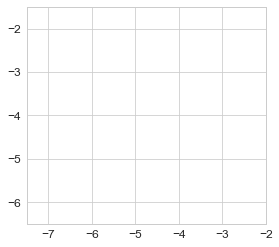

array([[[-7.5   , -7.5   , -7.5   , -7.5   , -7.5   , -7.5   , -7.5   ,
         -7.5   , -7.5   ],
        [-6.8125, -6.8125, -6.8125, -6.8125, -6.8125, -6.8125, -6.8125,
         -6.8125, -6.8125],
        [-6.125 , -6.125 , -6.125 , -6.125 , -6.125 , -6.125 , -6.125 ,
         -6.125 , -6.125 ],
        [-5.4375, -5.4375, -5.4375, -5.4375, -5.4375, -5.4375, -5.4375,
         -5.4375, -5.4375],
        [-4.75  , -4.75  , -4.75  , -4.75  , -4.75  , -4.75  , -4.75  ,
         -4.75  , -4.75  ],
        [-4.0625, -4.0625, -4.0625, -4.0625, -4.0625, -4.0625, -4.0625,
         -4.0625, -4.0625],
        [-3.375 , -3.375 , -3.375 , -3.375 , -3.375 , -3.375 , -3.375 ,
         -3.375 , -3.375 ],
        [-2.6875, -2.6875, -2.6875, -2.6875, -2.6875, -2.6875, -2.6875,
         -2.6875, -2.6875],
        [-2.    , -2.    , -2.    , -2.    , -2.    , -2.    , -2.    ,
         -2.    , -2.    ]],

       [[-6.5   , -5.875 , -5.25  , -4.625 , -4.    , -3.375 , -2.75  ,
         -2.125 , -1.5   ]

In [2]:
carbon_range = (-7.5, -2)
oxygen_range = (-6.5, -1.5)
grid_size = 9
mesh  = np.mgrid[carbon_range[0]:carbon_range[1]:grid_size*1j, 
                 oxygen_range[0]:oxygen_range[1]:grid_size*1j]

with sns.axes_style("whitegrid"):
    plt.axis('square')
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
plt.show()
    
mesh

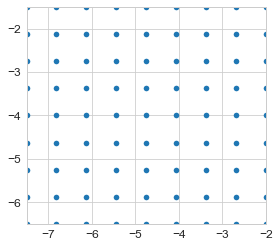

In [3]:
experiments = mesh.reshape((2,-1)).T

with sns.axes_style("whitegrid"):
    plt.axis('square')
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
    plt.plot(*experiments.T, marker='o', linestyle='none')

In [4]:
extent = carbon_range + oxygen_range

# Because the center of a corner pixel is in fact the corner of the grid# Becaus 
# we want to stretch the image a little
c_step = mesh[0,1,0]-mesh[0,0,0]
o_step = mesh[1,0,1]-mesh[1,0,0]
carbon_range2 = (carbon_range[0]-c_step/2, carbon_range[1]+c_step/2)
oxygen_range2 = (oxygen_range[0]-c_step/2, oxygen_range[1]+c_step/2)
extent2 = carbon_range2 + oxygen_range2

In [5]:
# smoosh all csv files together
array = os.listdir('./linearscaling/')
array = sorted(array)

reactions = []
num_surf_reactions = []
times = []
count = 1
c_s = []
o_s = []
for x in array:
    _, c, o = x.split("-")
    c = c[:-1]
    c = -1 *float(c)
    o = -1* float(o)
    c_s.append(c)
    o_s.append(o)
    try:
        data = pd.read_csv('./linearscaling/' + x + '/dict.csv', header=None)
        
        time = float(open(os.path.join('linearscaling',x,'time.txt')).read())
        times.append(time)
        
        # get the reactions
        rxns = []
        n = []
        for y in data[1]:
            rxns.append(y)
        for y in data[2]:
            n.append([y])
        zipped = zip(rxns,n)
        zipped = [list(z) for z in zipped]
        #counting number of surface reactions in each 
        num_surf_reactions.append(len(zipped))
#         if reactions == []:
#             reactions = zipped

        if count is 1:
            reactions = zipped
        else:
            # add the reactions that already have a match
            for rxn in reactions:
                for a in zipped:
                    if a[0] == rxn[0]:
                        rxn[1].append(a[1][0])
                        zipped.remove(a)
            # add 0s to the reactions that don't occur in this model
            for f in reactions:
                if len(f[1]) is not count:
                    f[1].append(1E-9)
            # add the new reactions
            for a in zipped:
                if len(a[1]) is not count:
                    zeros = [1E-9] * (count - len(a[1]))
                    a[1] = zeros + a[1]
                    reactions.append(a)
        count += 1
    except:
        print '%s does not have a dict.csv file'%(x)
        if reactions == []:
            if count is 1:
                reactions = [['placeholder',[1E-9]]]
        else:
            for f in reactions:
                if len(f[1]) is not count:
                    f[1].append(1E-9)
        count += 1
        times.append(1e9)
              
# for s in reactions:
#     print s
del reactions[0]

c-2.000o-1.500 does not have a dict.csv file
c-2.000o-2.125 does not have a dict.csv file
c-2.000o-2.750 does not have a dict.csv file
c-2.000o-3.375 does not have a dict.csv file
c-2.000o-4.000 does not have a dict.csv file
c-2.000o-4.625 does not have a dict.csv file
c-2.000o-5.250 does not have a dict.csv file
c-2.000o-5.875 does not have a dict.csv file
c-2.000o-6.500 does not have a dict.csv file
c-2.688o-1.500 does not have a dict.csv file
c-2.688o-2.125 does not have a dict.csv file
c-2.688o-2.750 does not have a dict.csv file
c-2.688o-3.375 does not have a dict.csv file
c-2.688o-4.000 does not have a dict.csv file
c-2.688o-4.625 does not have a dict.csv file
c-2.688o-5.250 does not have a dict.csv file
c-2.688o-5.875 does not have a dict.csv file
c-2.688o-6.500 does not have a dict.csv file
c-3.375o-1.500 does not have a dict.csv file
c-3.375o-2.125 does not have a dict.csv file
c-3.375o-2.750 does not have a dict.csv file
c-3.375o-3.375 does not have a dict.csv file
c-3.375o-4

In [6]:
# For close packed surfaces from
# Abild-Pedersen, F.; Greeley, J.; Studt, F.; Rossmeisl, J.; Munter, T. R.; Moses, P. G.; Skúlason, E.; Bligaard, T.; Norskov, J. K. Scaling Properties of Adsorption Energies for Hydrogen-Containing Molecules on Transition-Metal Surfaces. Phys. Rev. Lett. 2007, 99 (1), 016105 DOI: 10.1103/PhysRevLett.99.016105.
abildpedersen_energies = { # Carbon, then Oxygen
'Ru': ( -6.397727272727272, -5.104763568600047),
'Rh': ( -6.5681818181818175, -4.609771721406942),
'Ni': ( -6.045454545454545, -4.711681807593758),
'Ir': ( -6.613636363636363, -5.94916142557652),
'Pd': ( -6, -3.517877940833916),
'Pt': ( -6.363636363636363, -3.481481481481482),
'Cu': ( -4.159090909090907, -3.85272536687631),
'Ag': ( -2.9545454545454533, -2.9282552993244817),
'Au': ( -3.7499999999999973, -2.302236198462614),
}

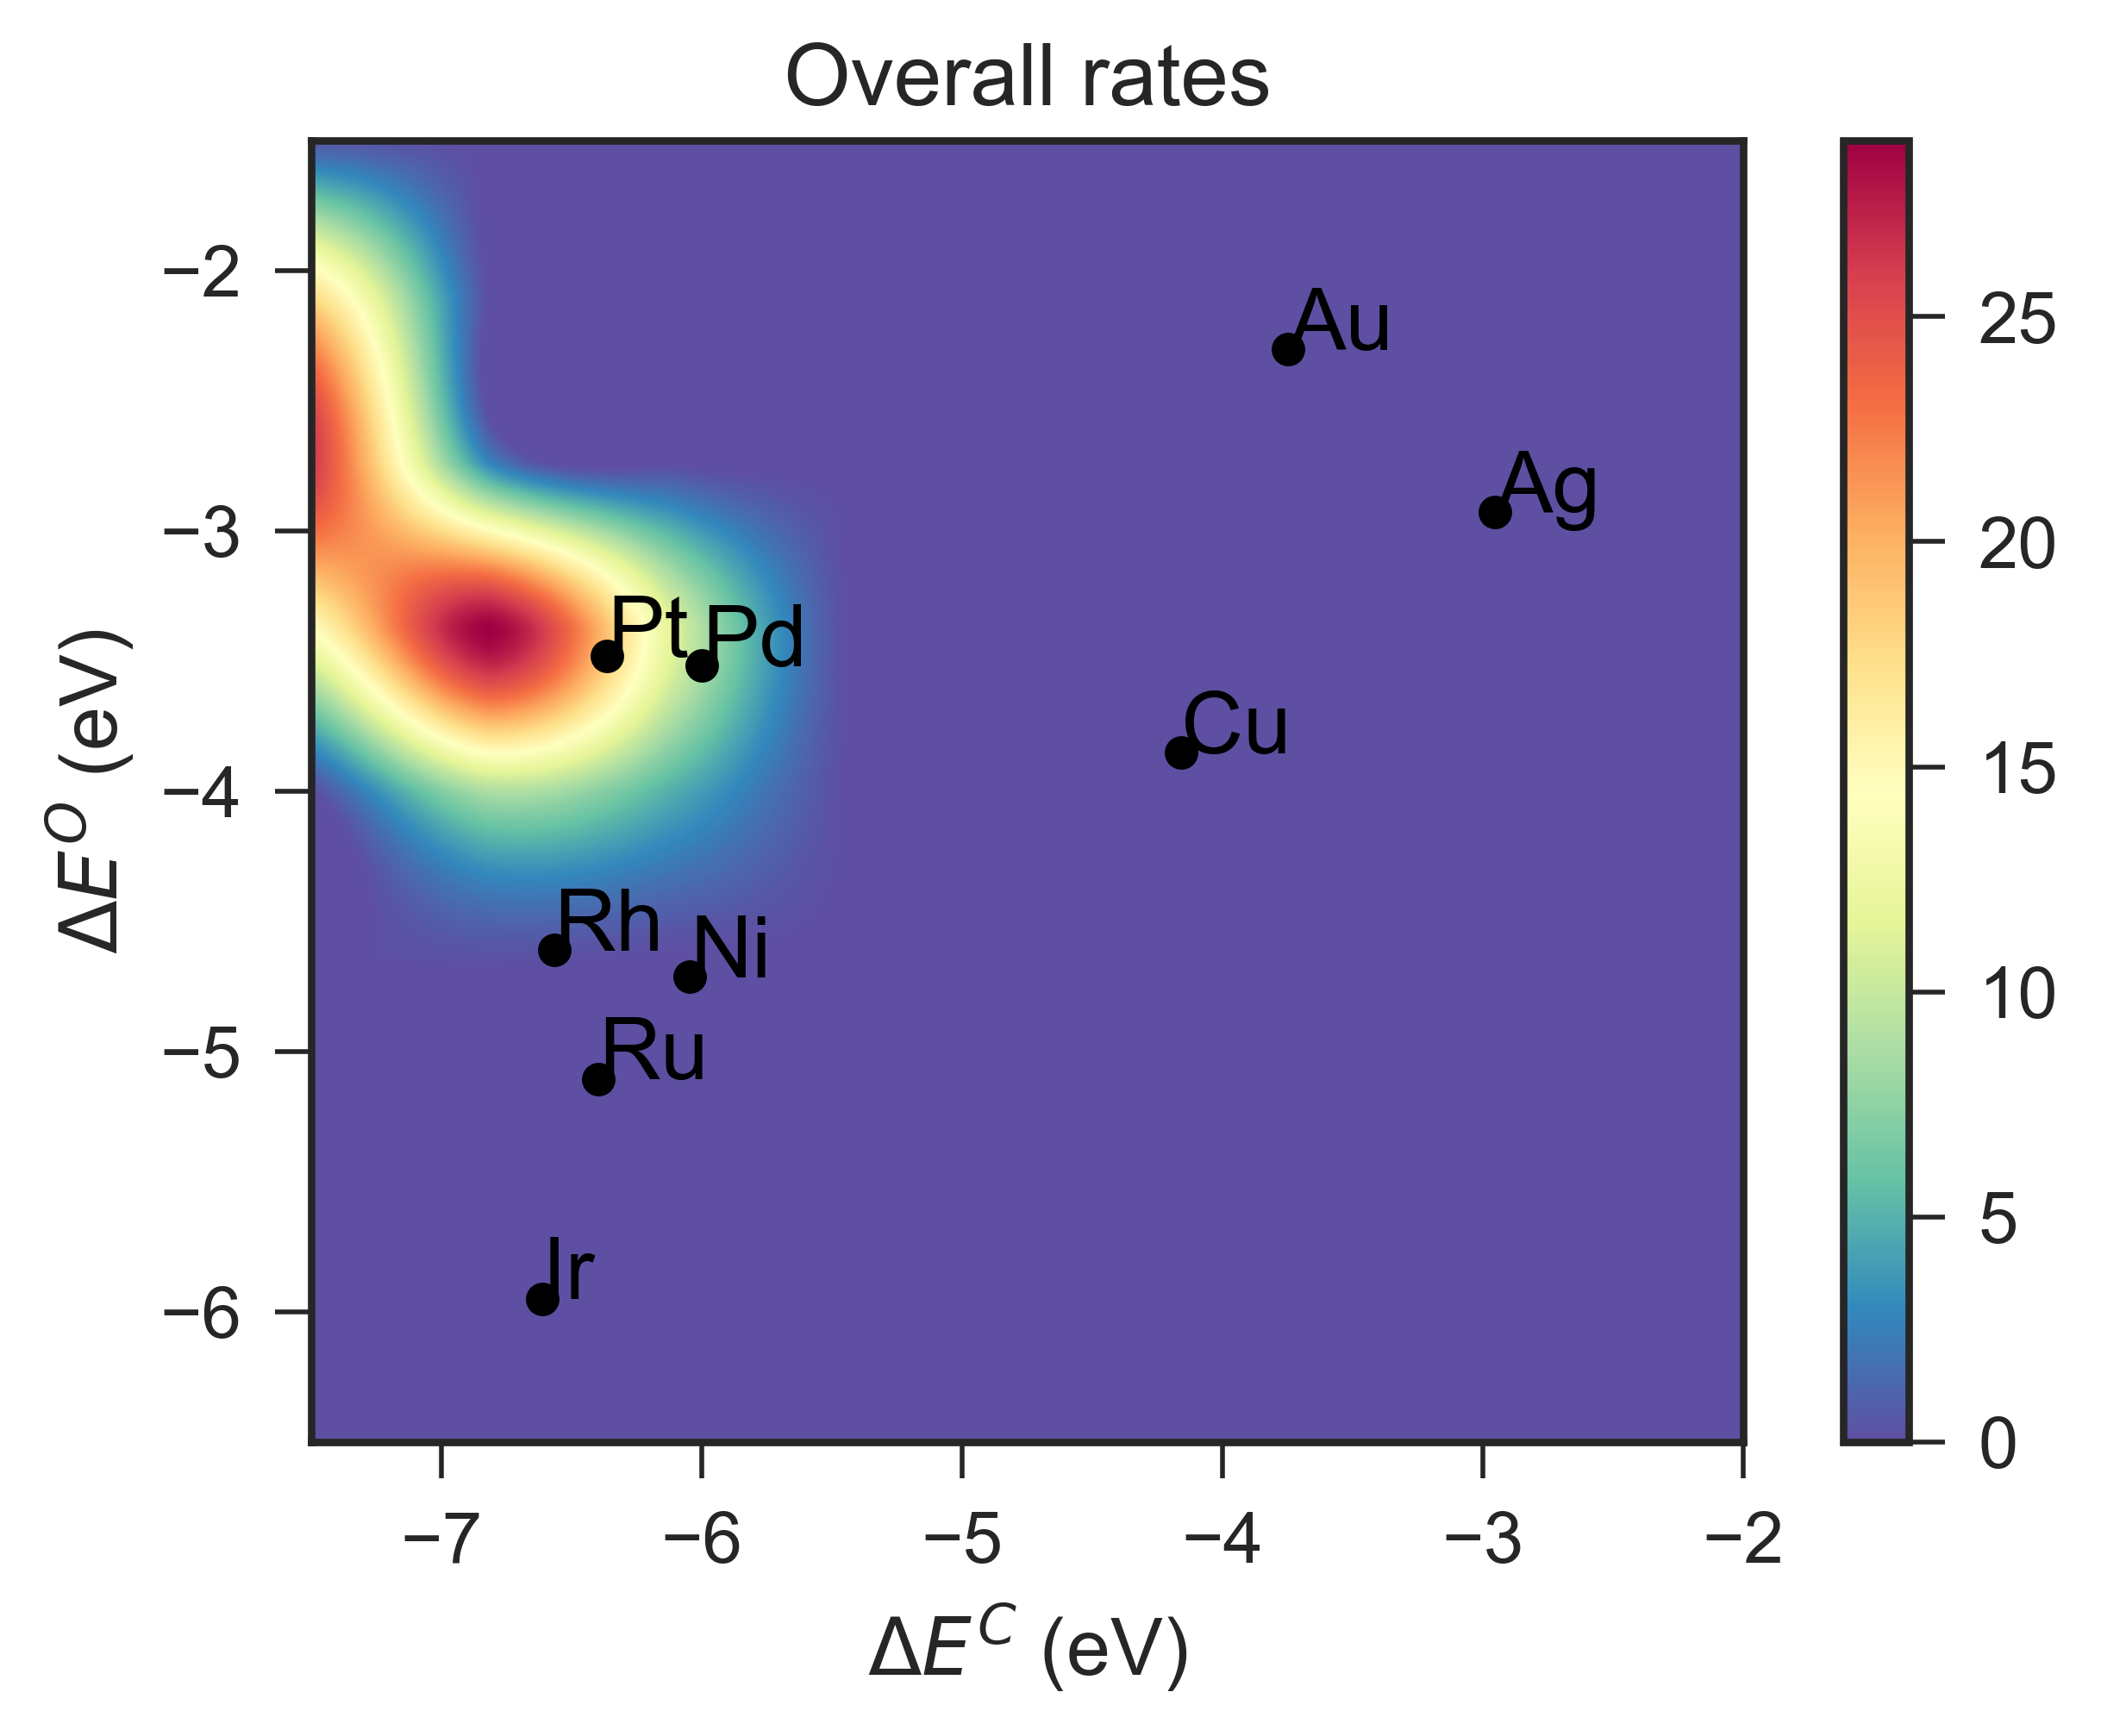

In [13]:
df = pd.DataFrame(index=np.unique(o_s), columns=np.unique(c_s))
for c, o, t in zip(c_s, o_s, times):
    df[c][o] = t
    
a = []
for i in df.values: 
    a = a + list(i)

times = np.array(times)
rates = 1./np.array(a)

rates_grid = np.reshape(rates, (grid_size,grid_size))

#ax = sns.heatmap(sensitivities_grid, cmap="Spectral")

plt.imshow(rates_grid, interpolation='spline16', origin='lower', 
           extent=extent2, aspect='equal', cmap="Spectral_r",)
for metal, coords in abildpedersen_energies.iteritems():
    color = {'Ag':'k','Au':'k','Cu':'k'}.get(metal,'k')
    plt.plot(coords[0], coords[1], 'o'+color)
    plt.text(coords[0], coords[1], metal, color=color)
plt.xlim(carbon_range)
plt.ylim(oxygen_range)
plt.xlabel('$\Delta E^C$ (eV)')
plt.ylabel('$\Delta E^O$ (eV)')
plt.title("Overall rates")
plt.colorbar()
plt.show()

# matplotlib.rcParams['figure.figsize'] = [10, 10]
# matplotlib.rcParams['figure.titlesize']
matplotlib.rcParams['figure.dpi'] = 500

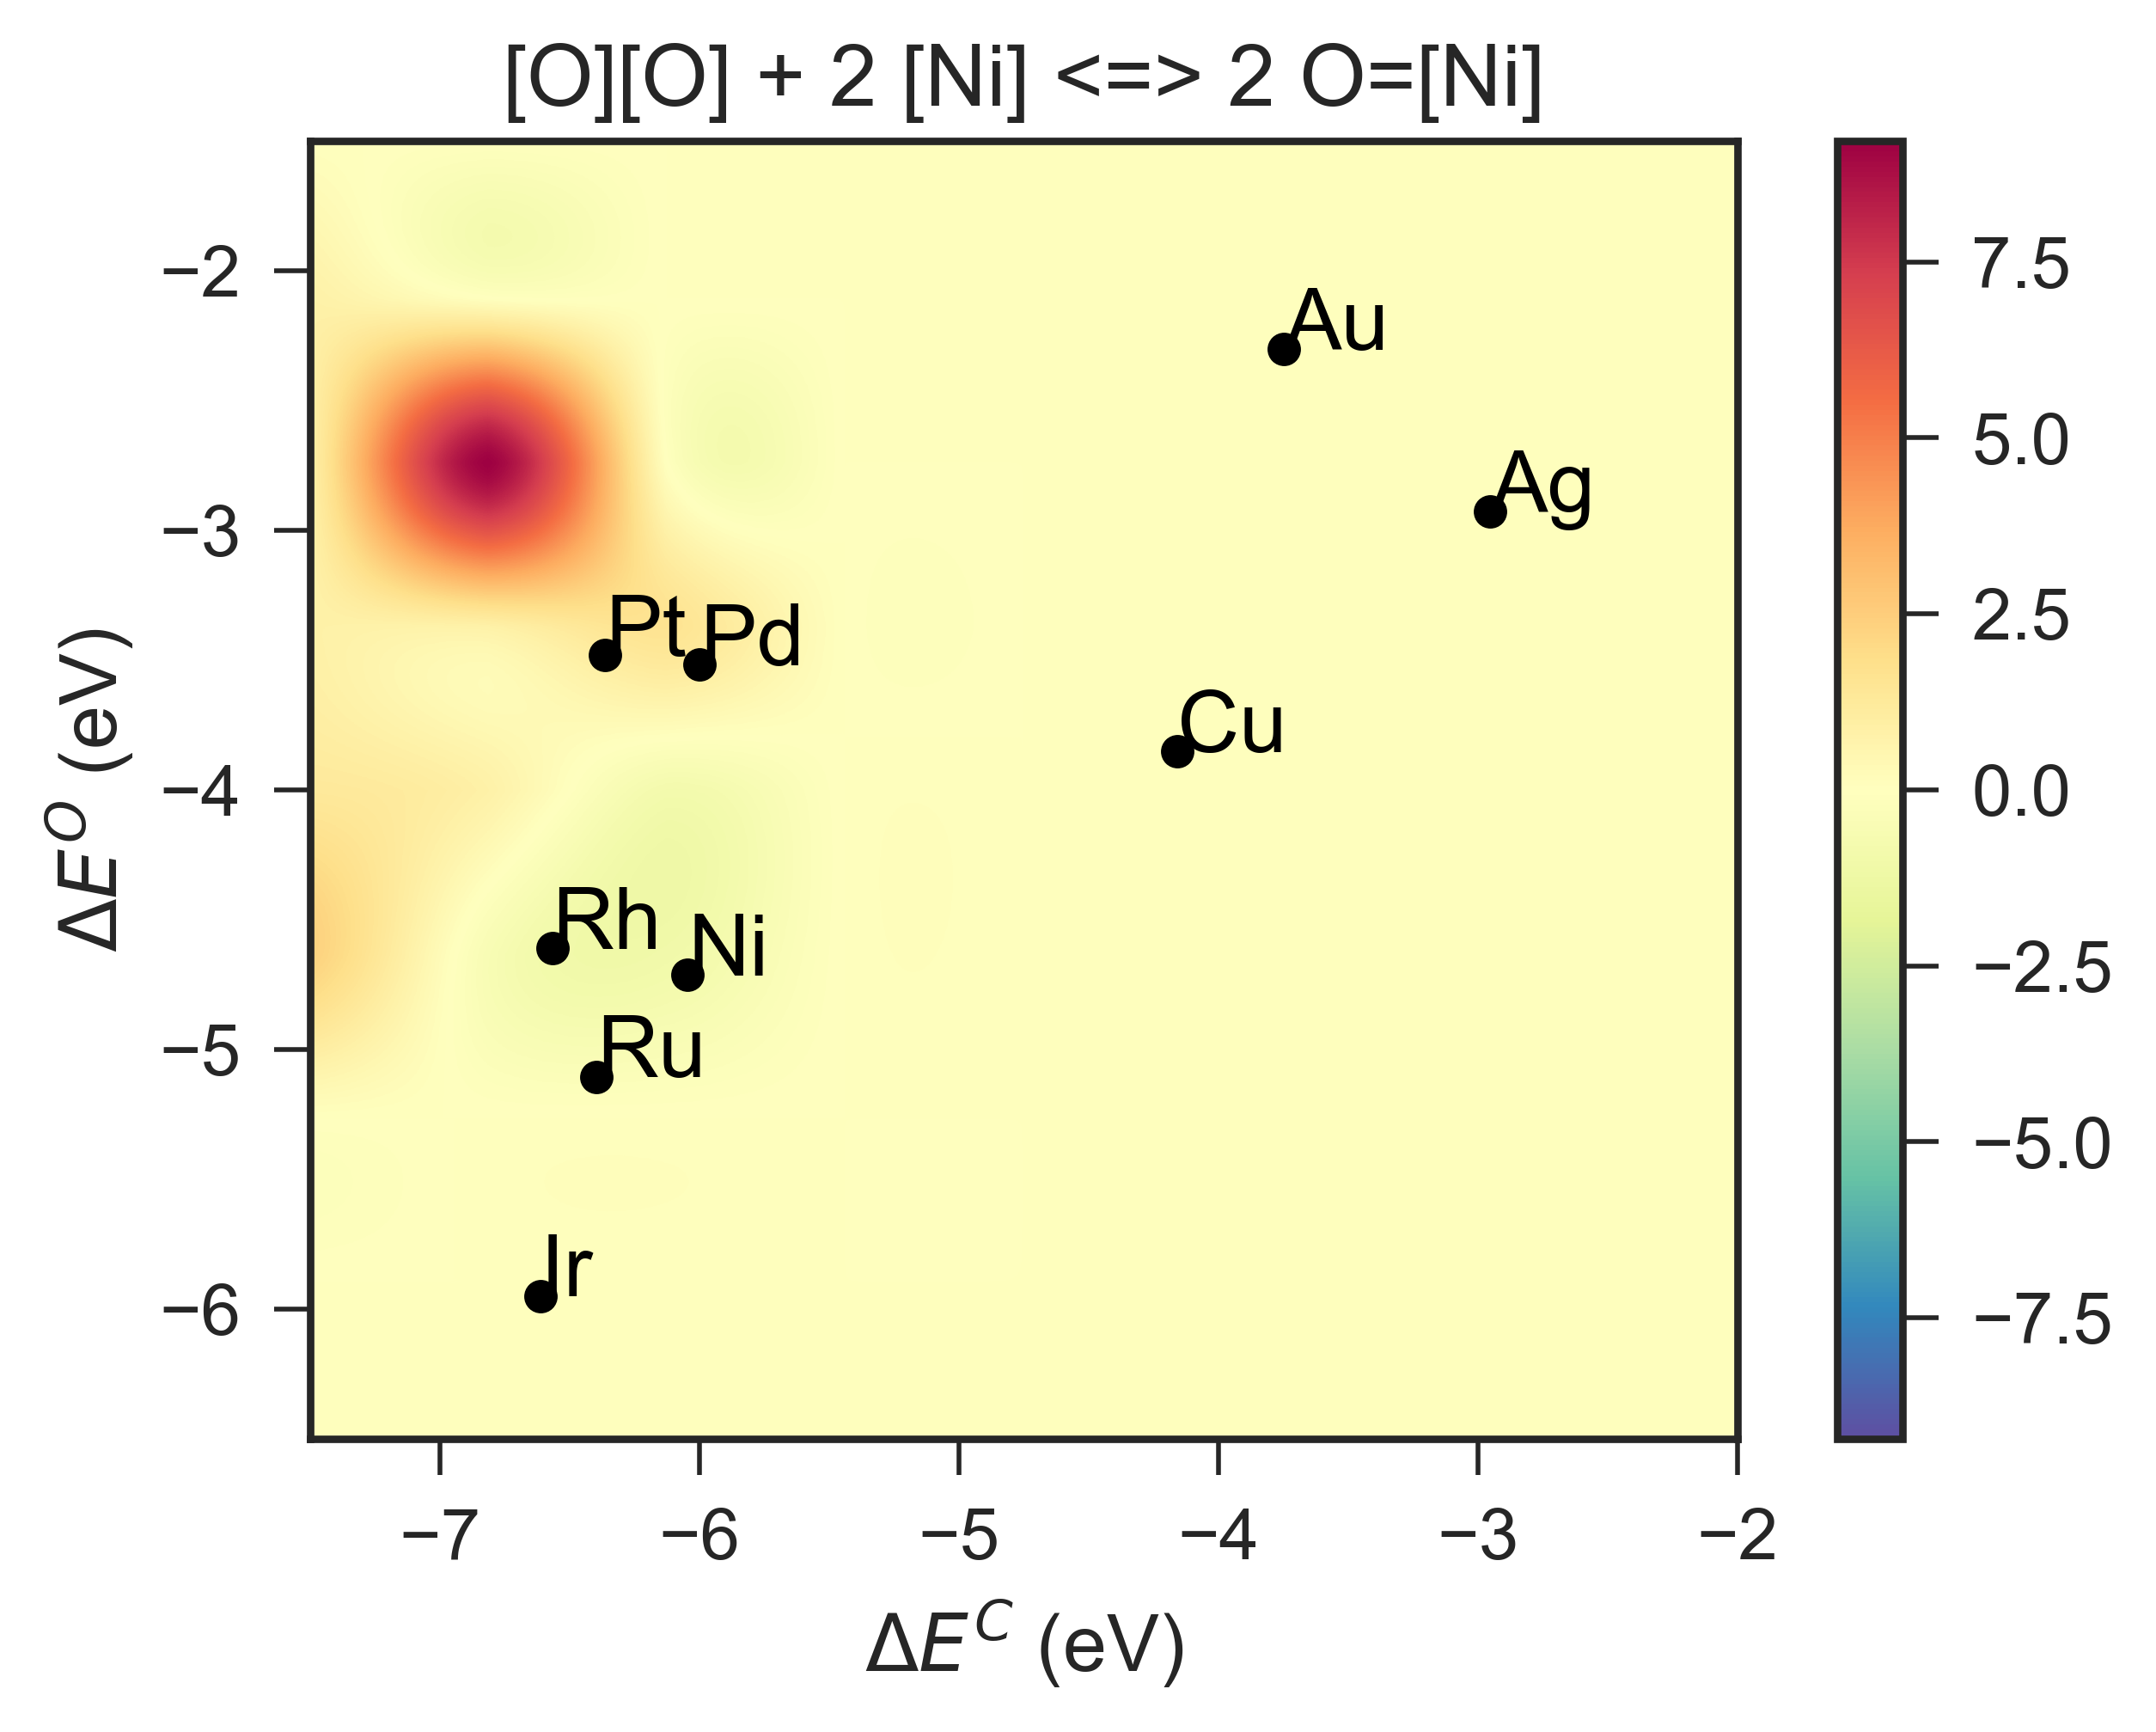

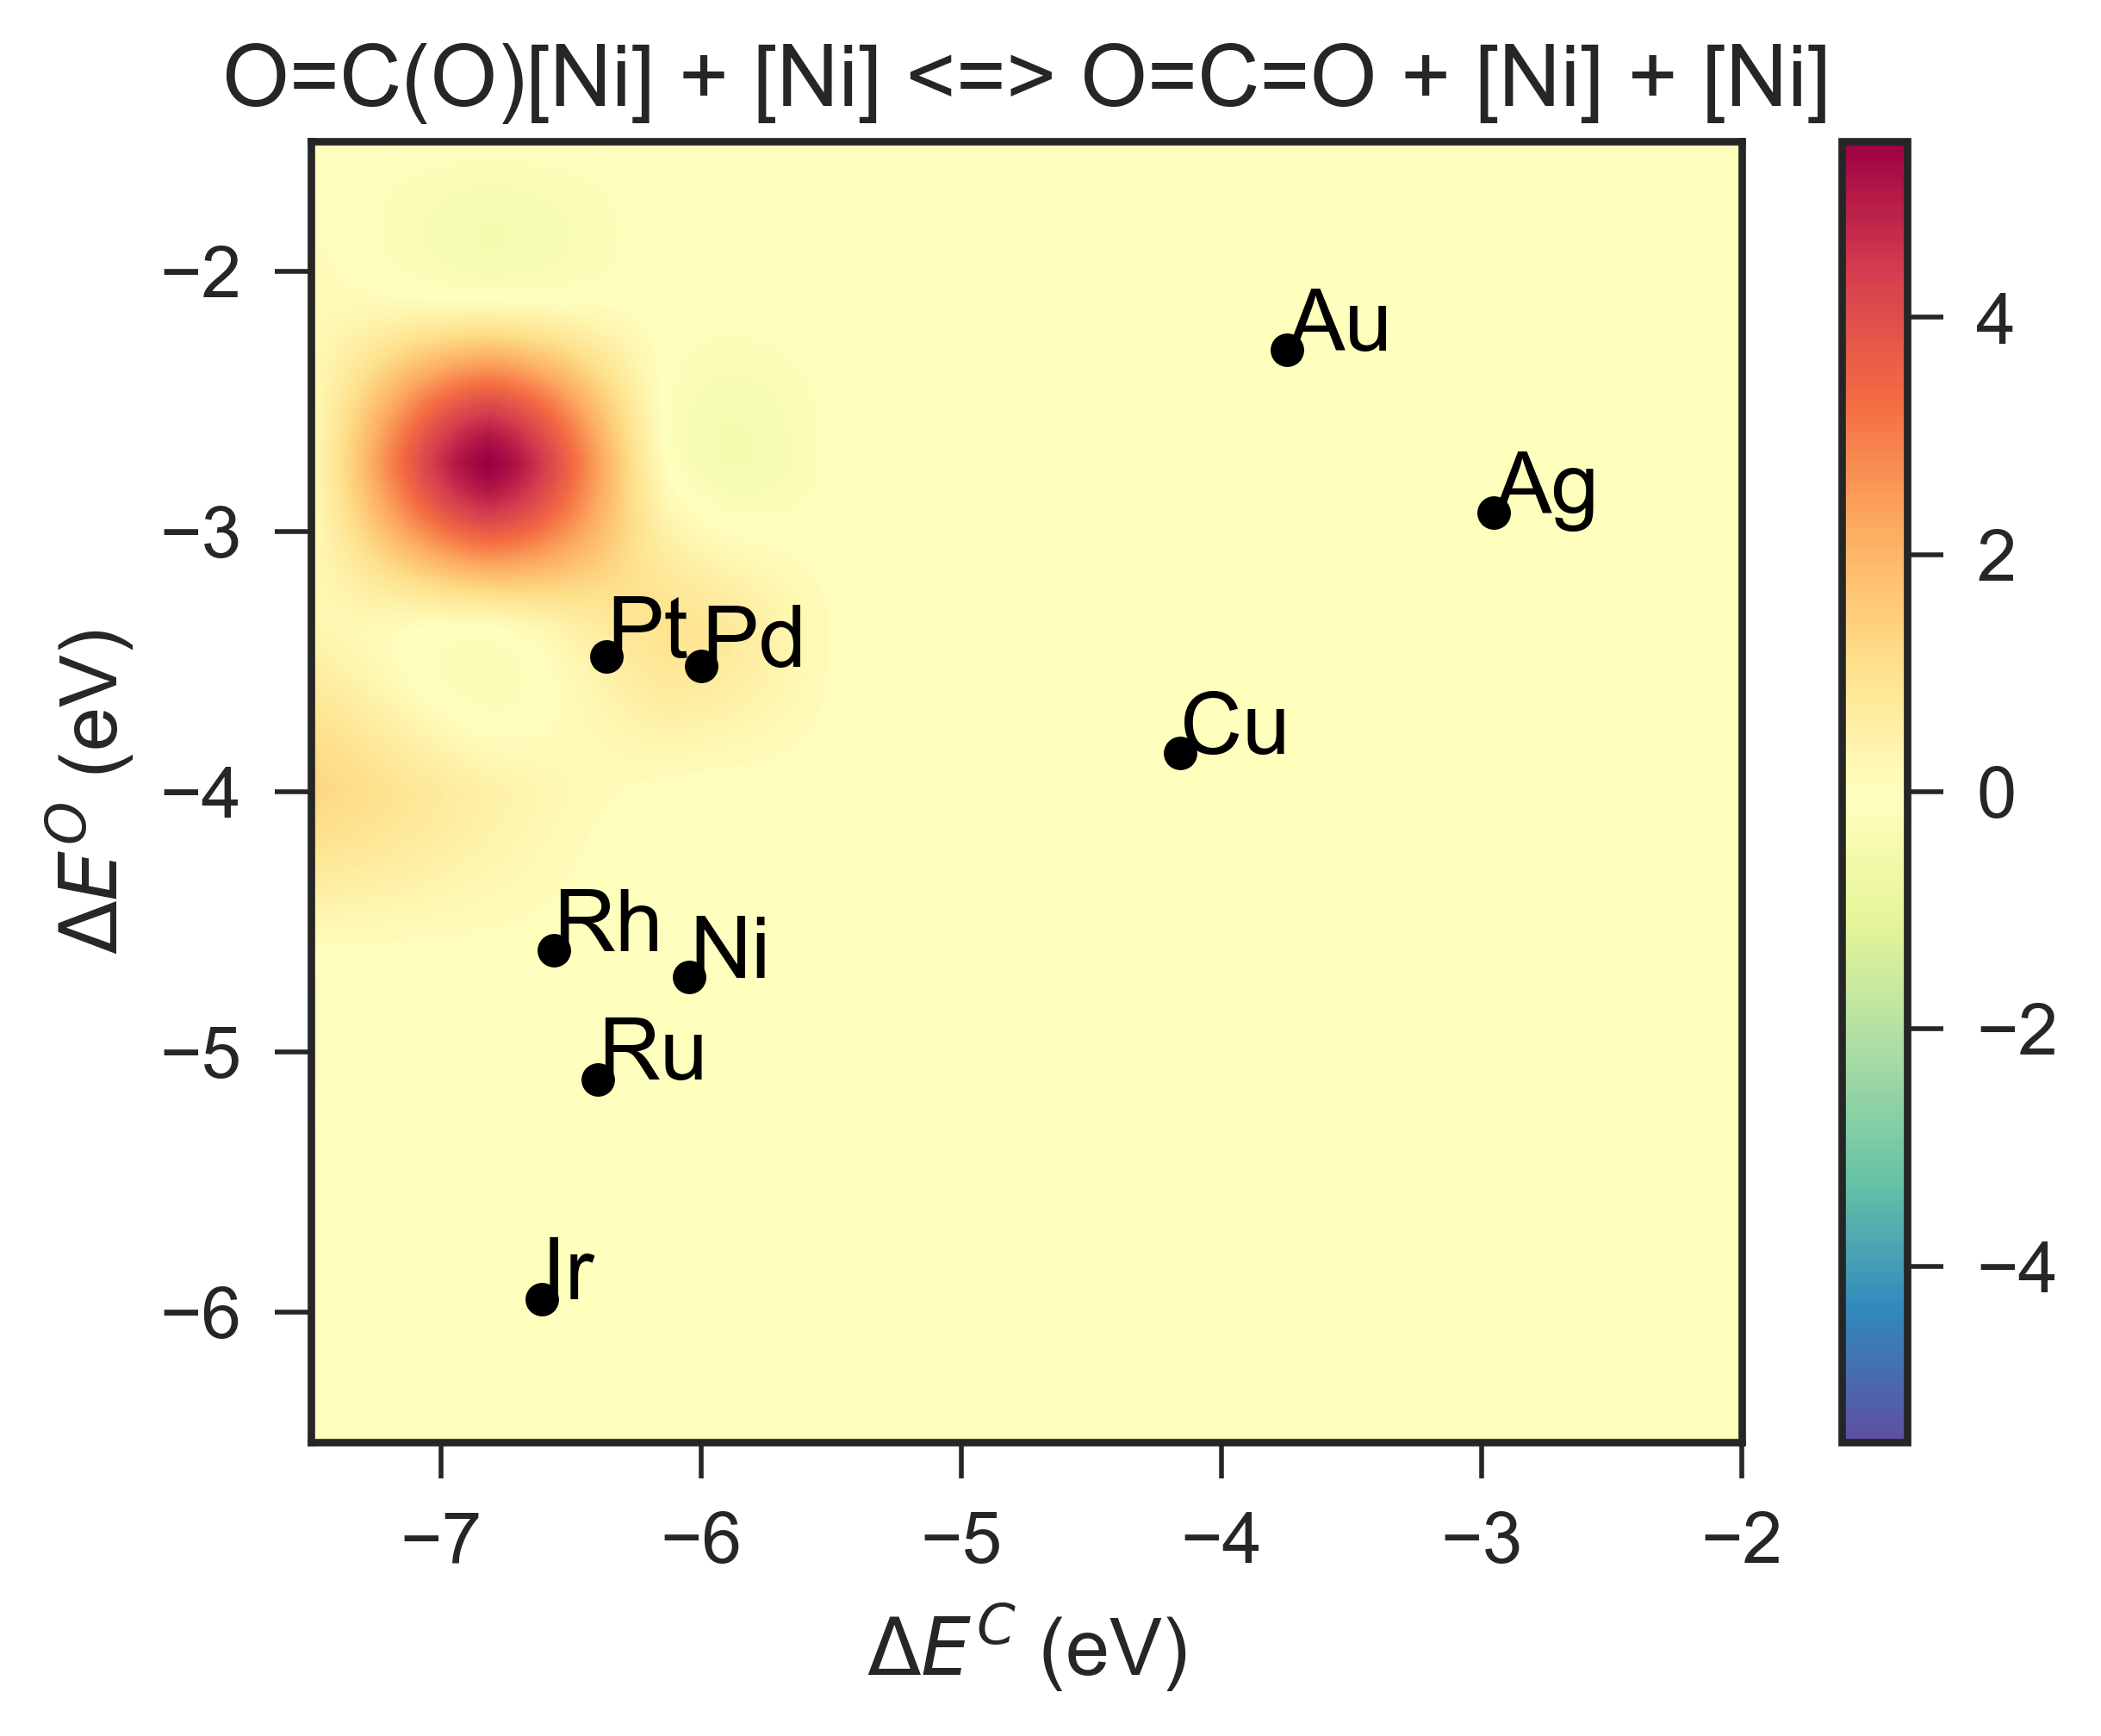

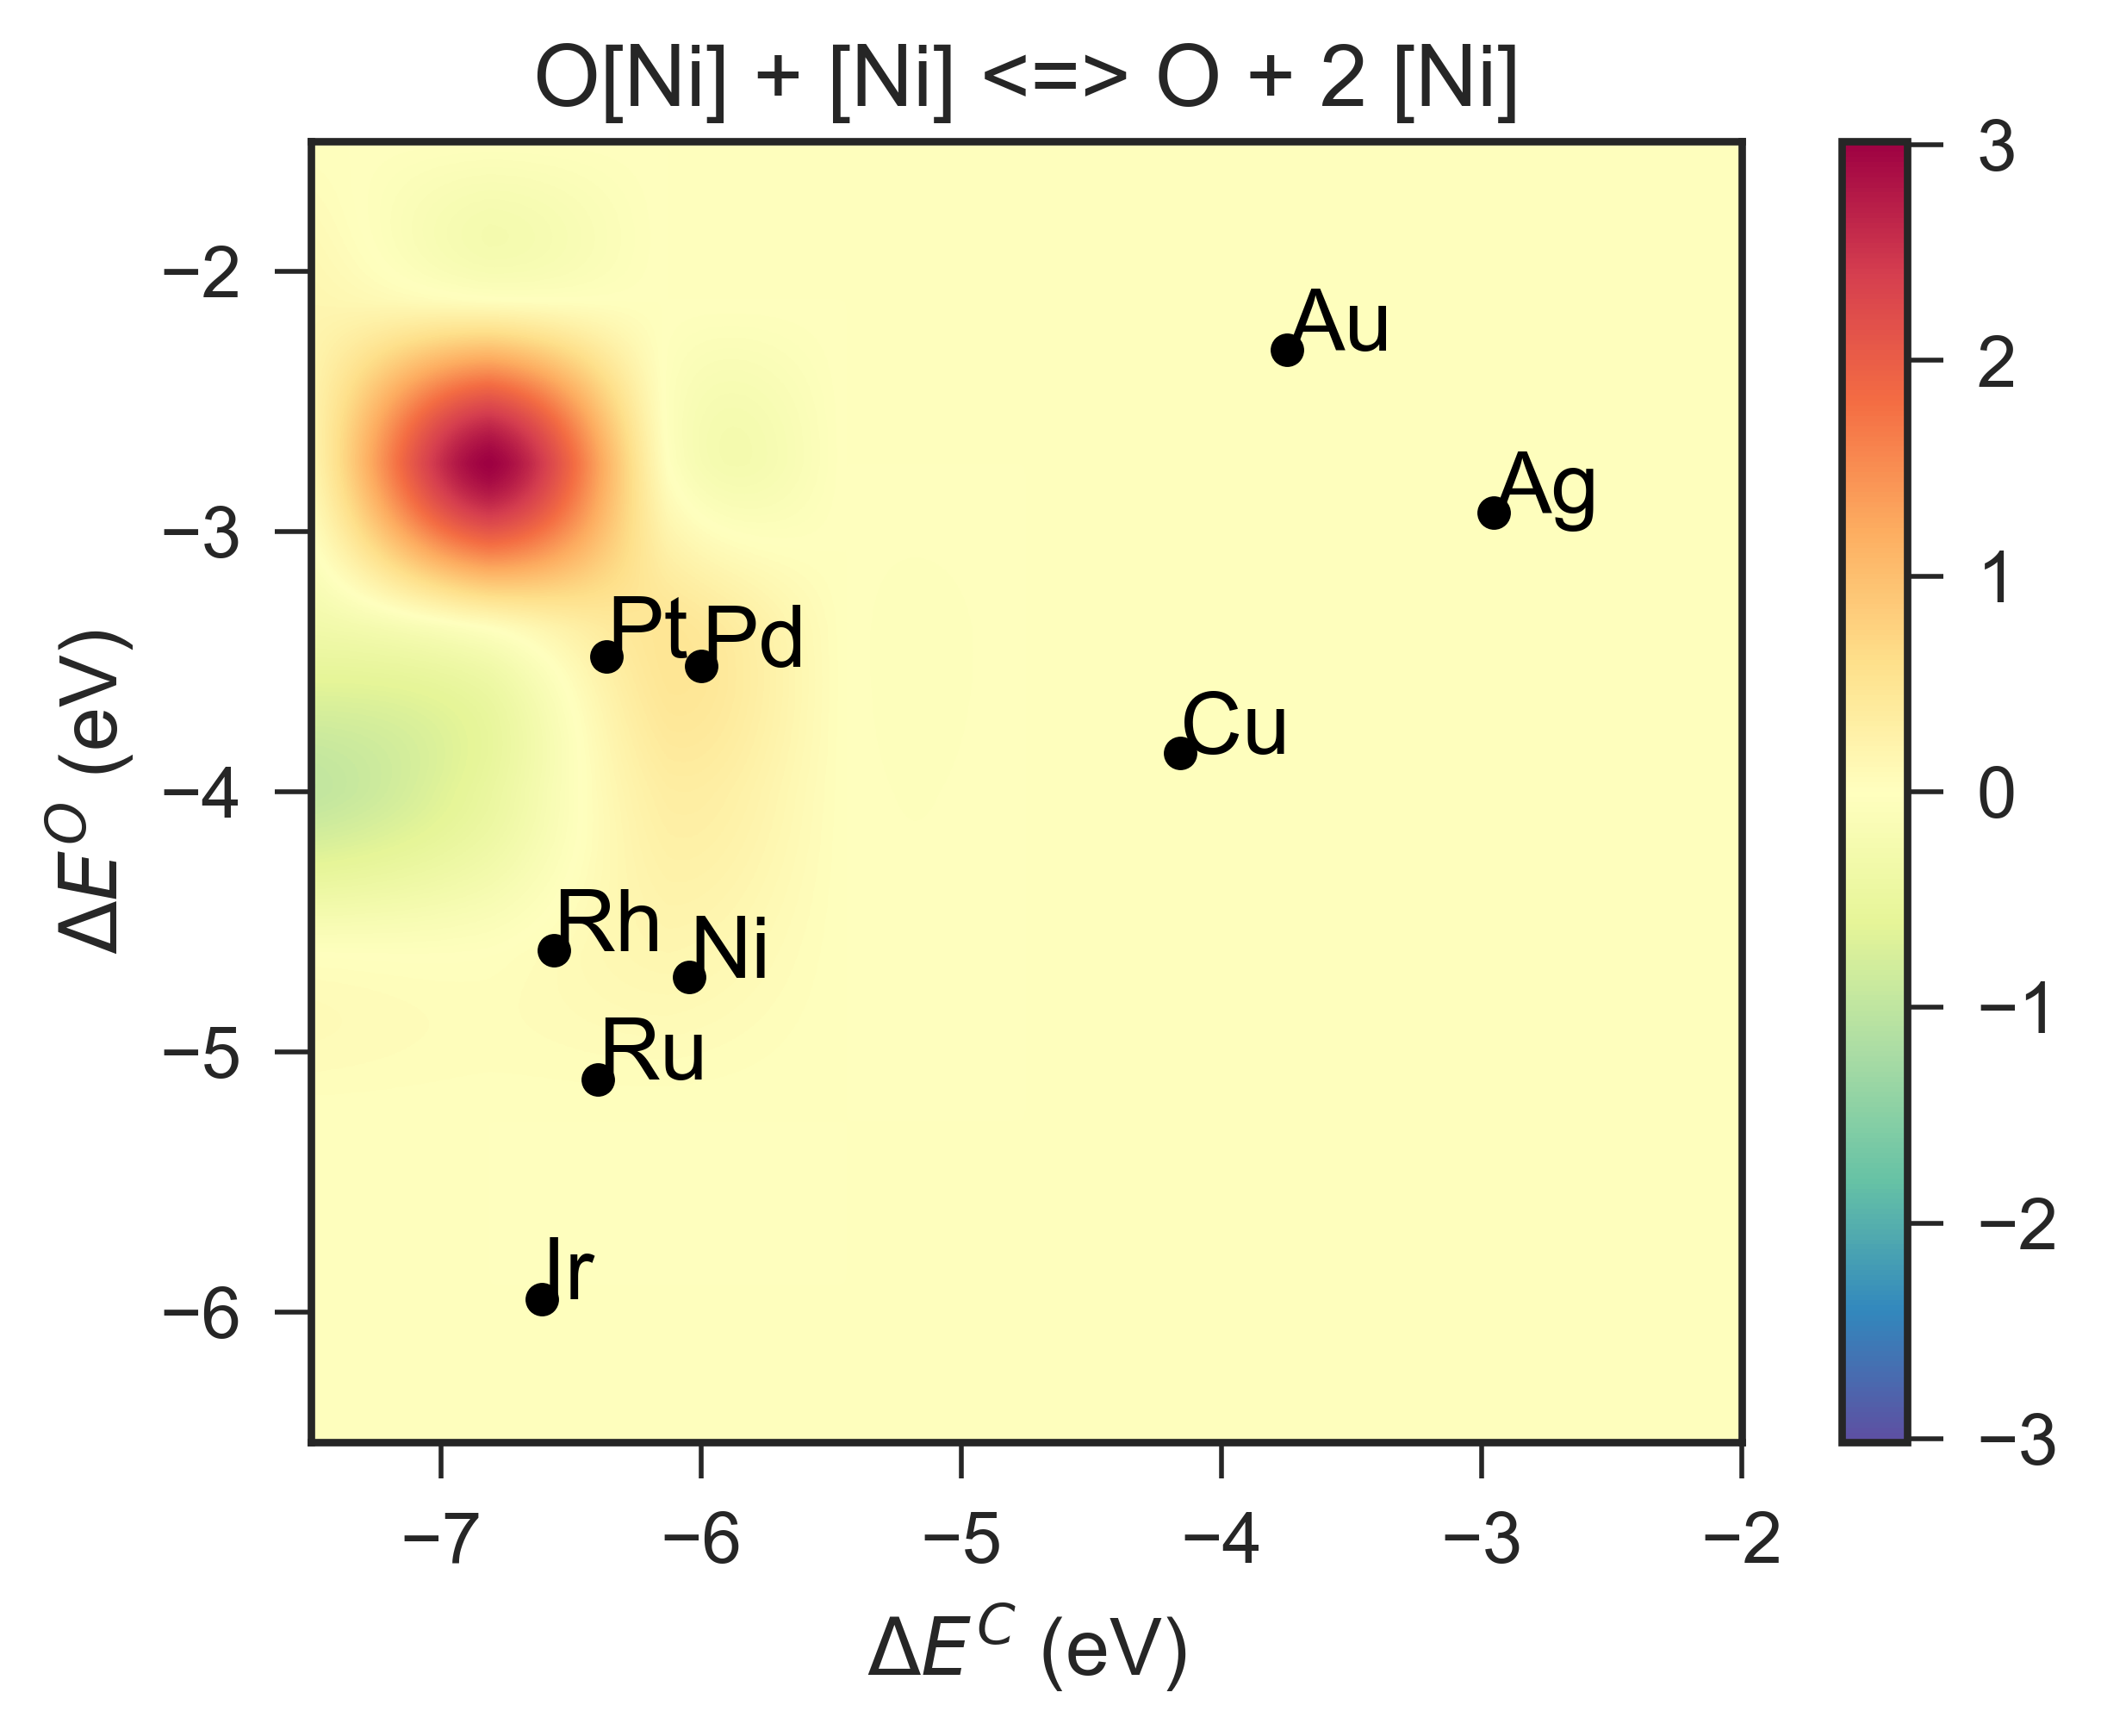

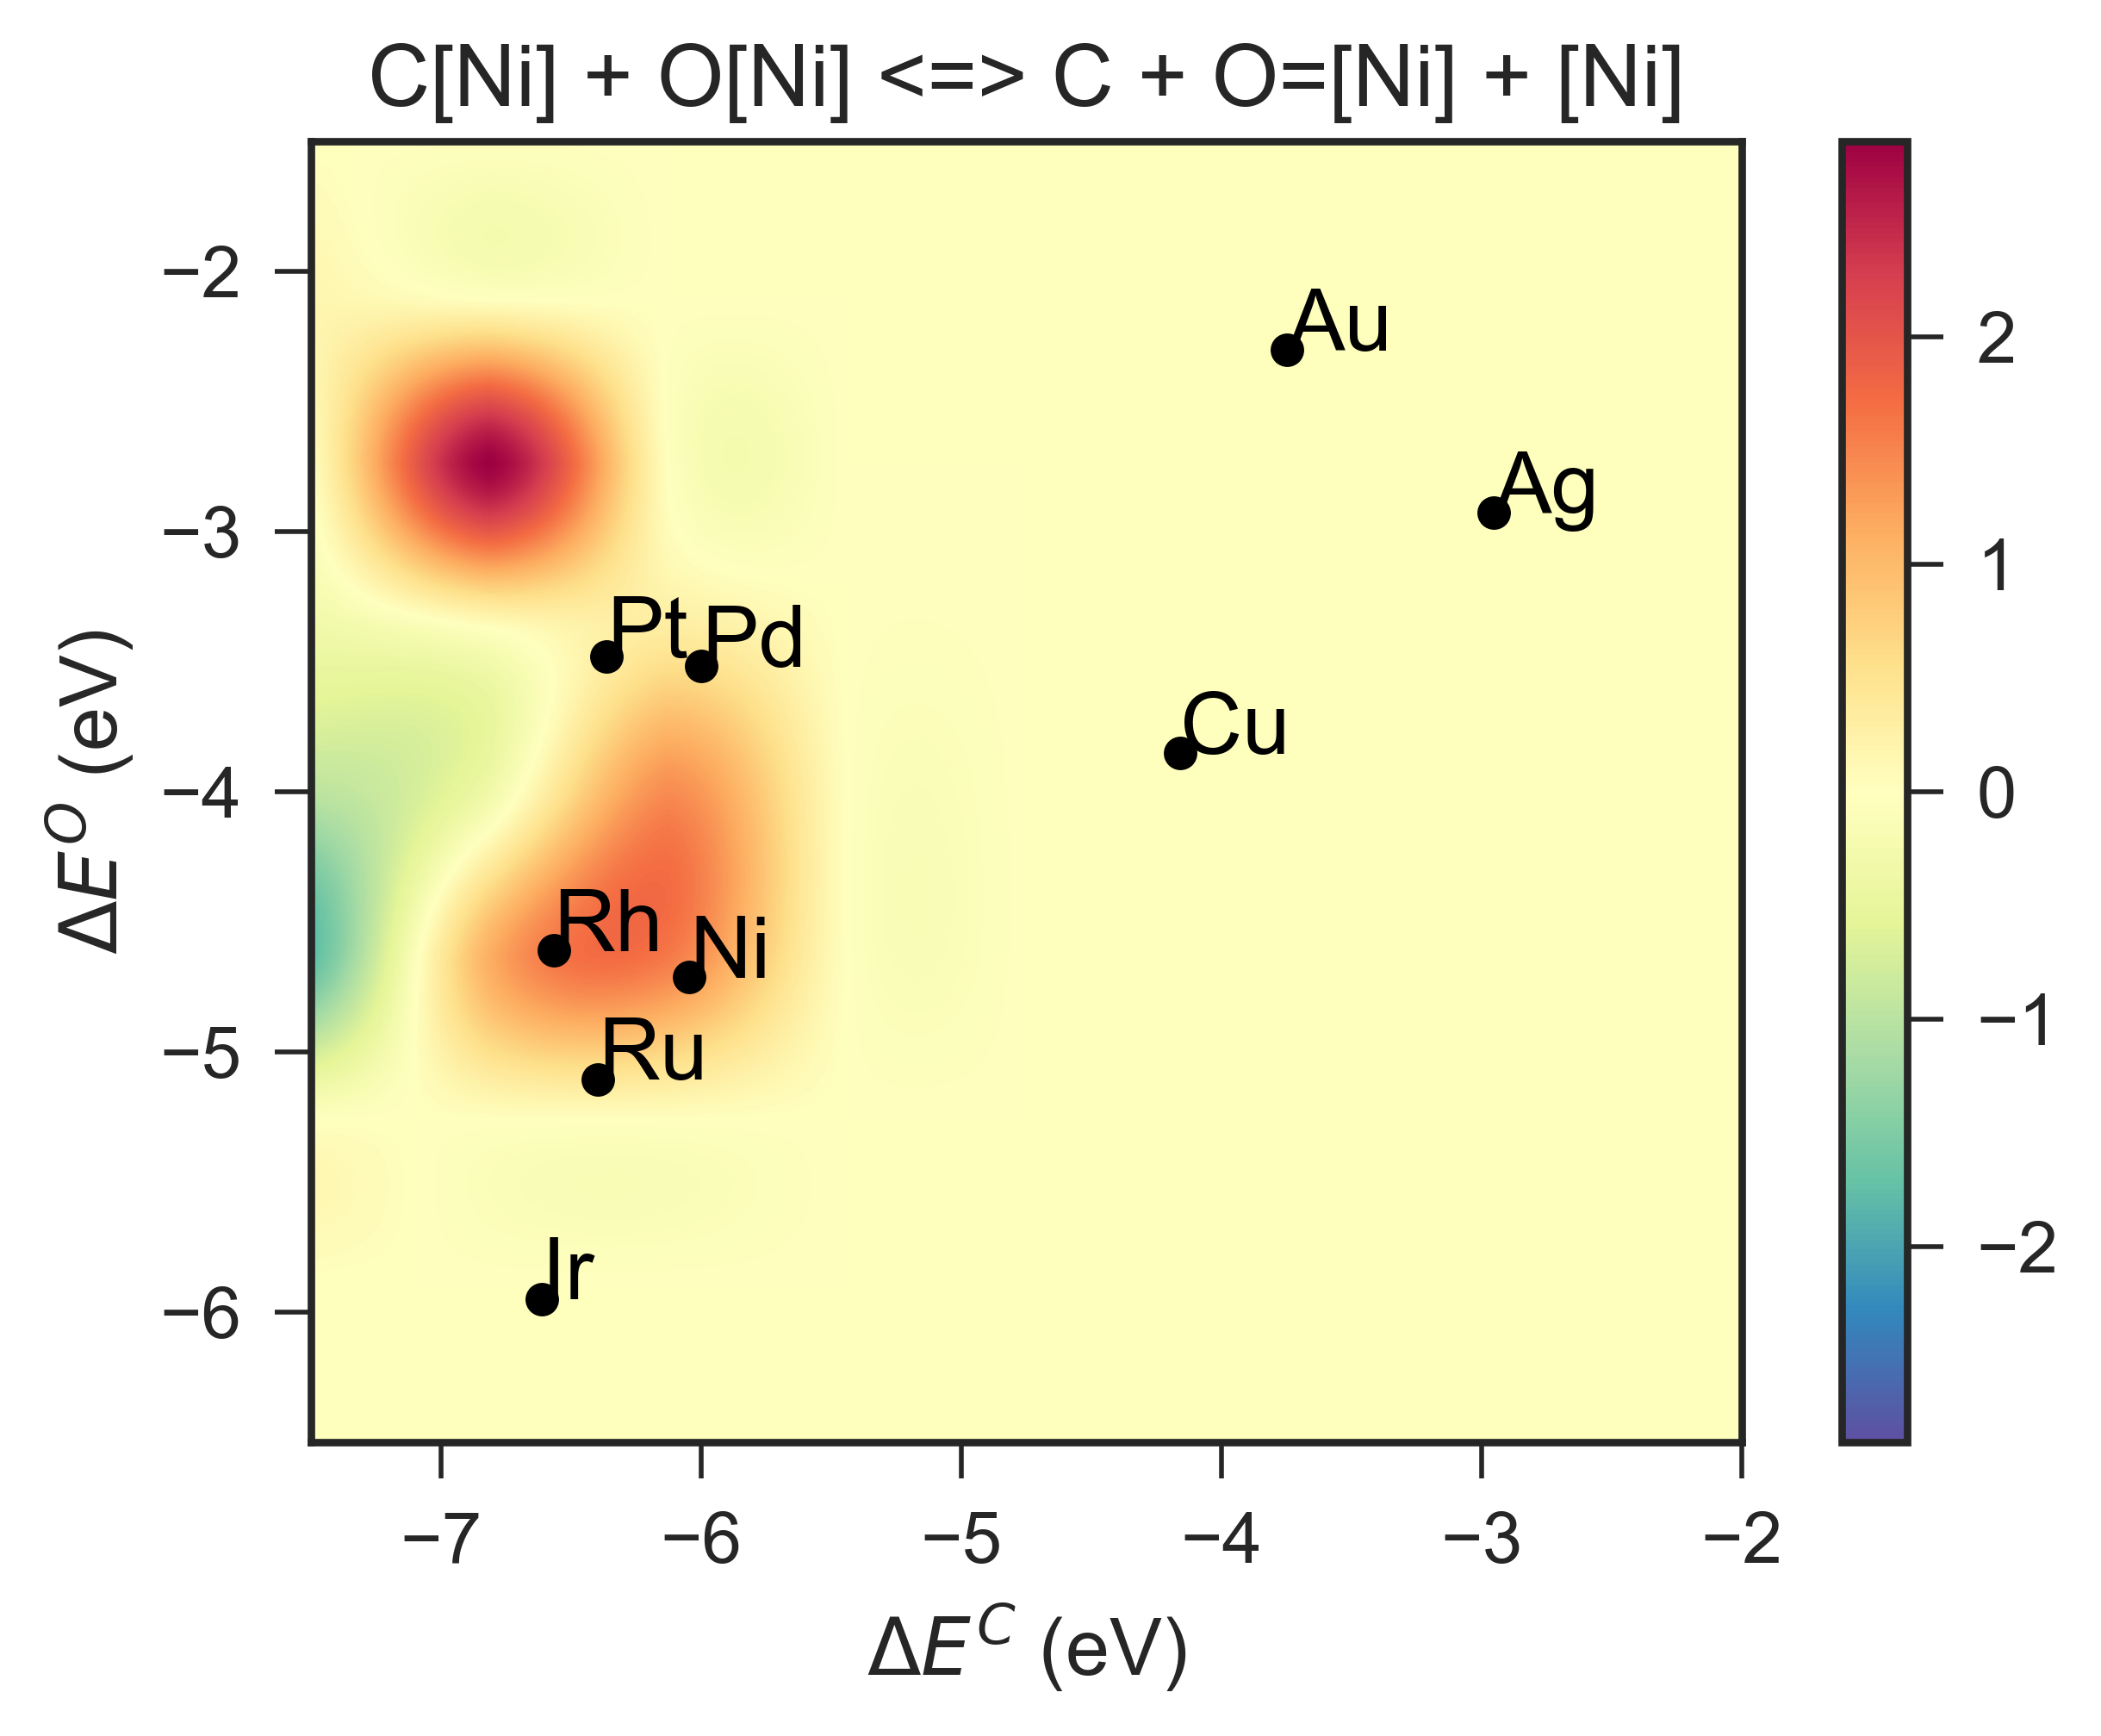

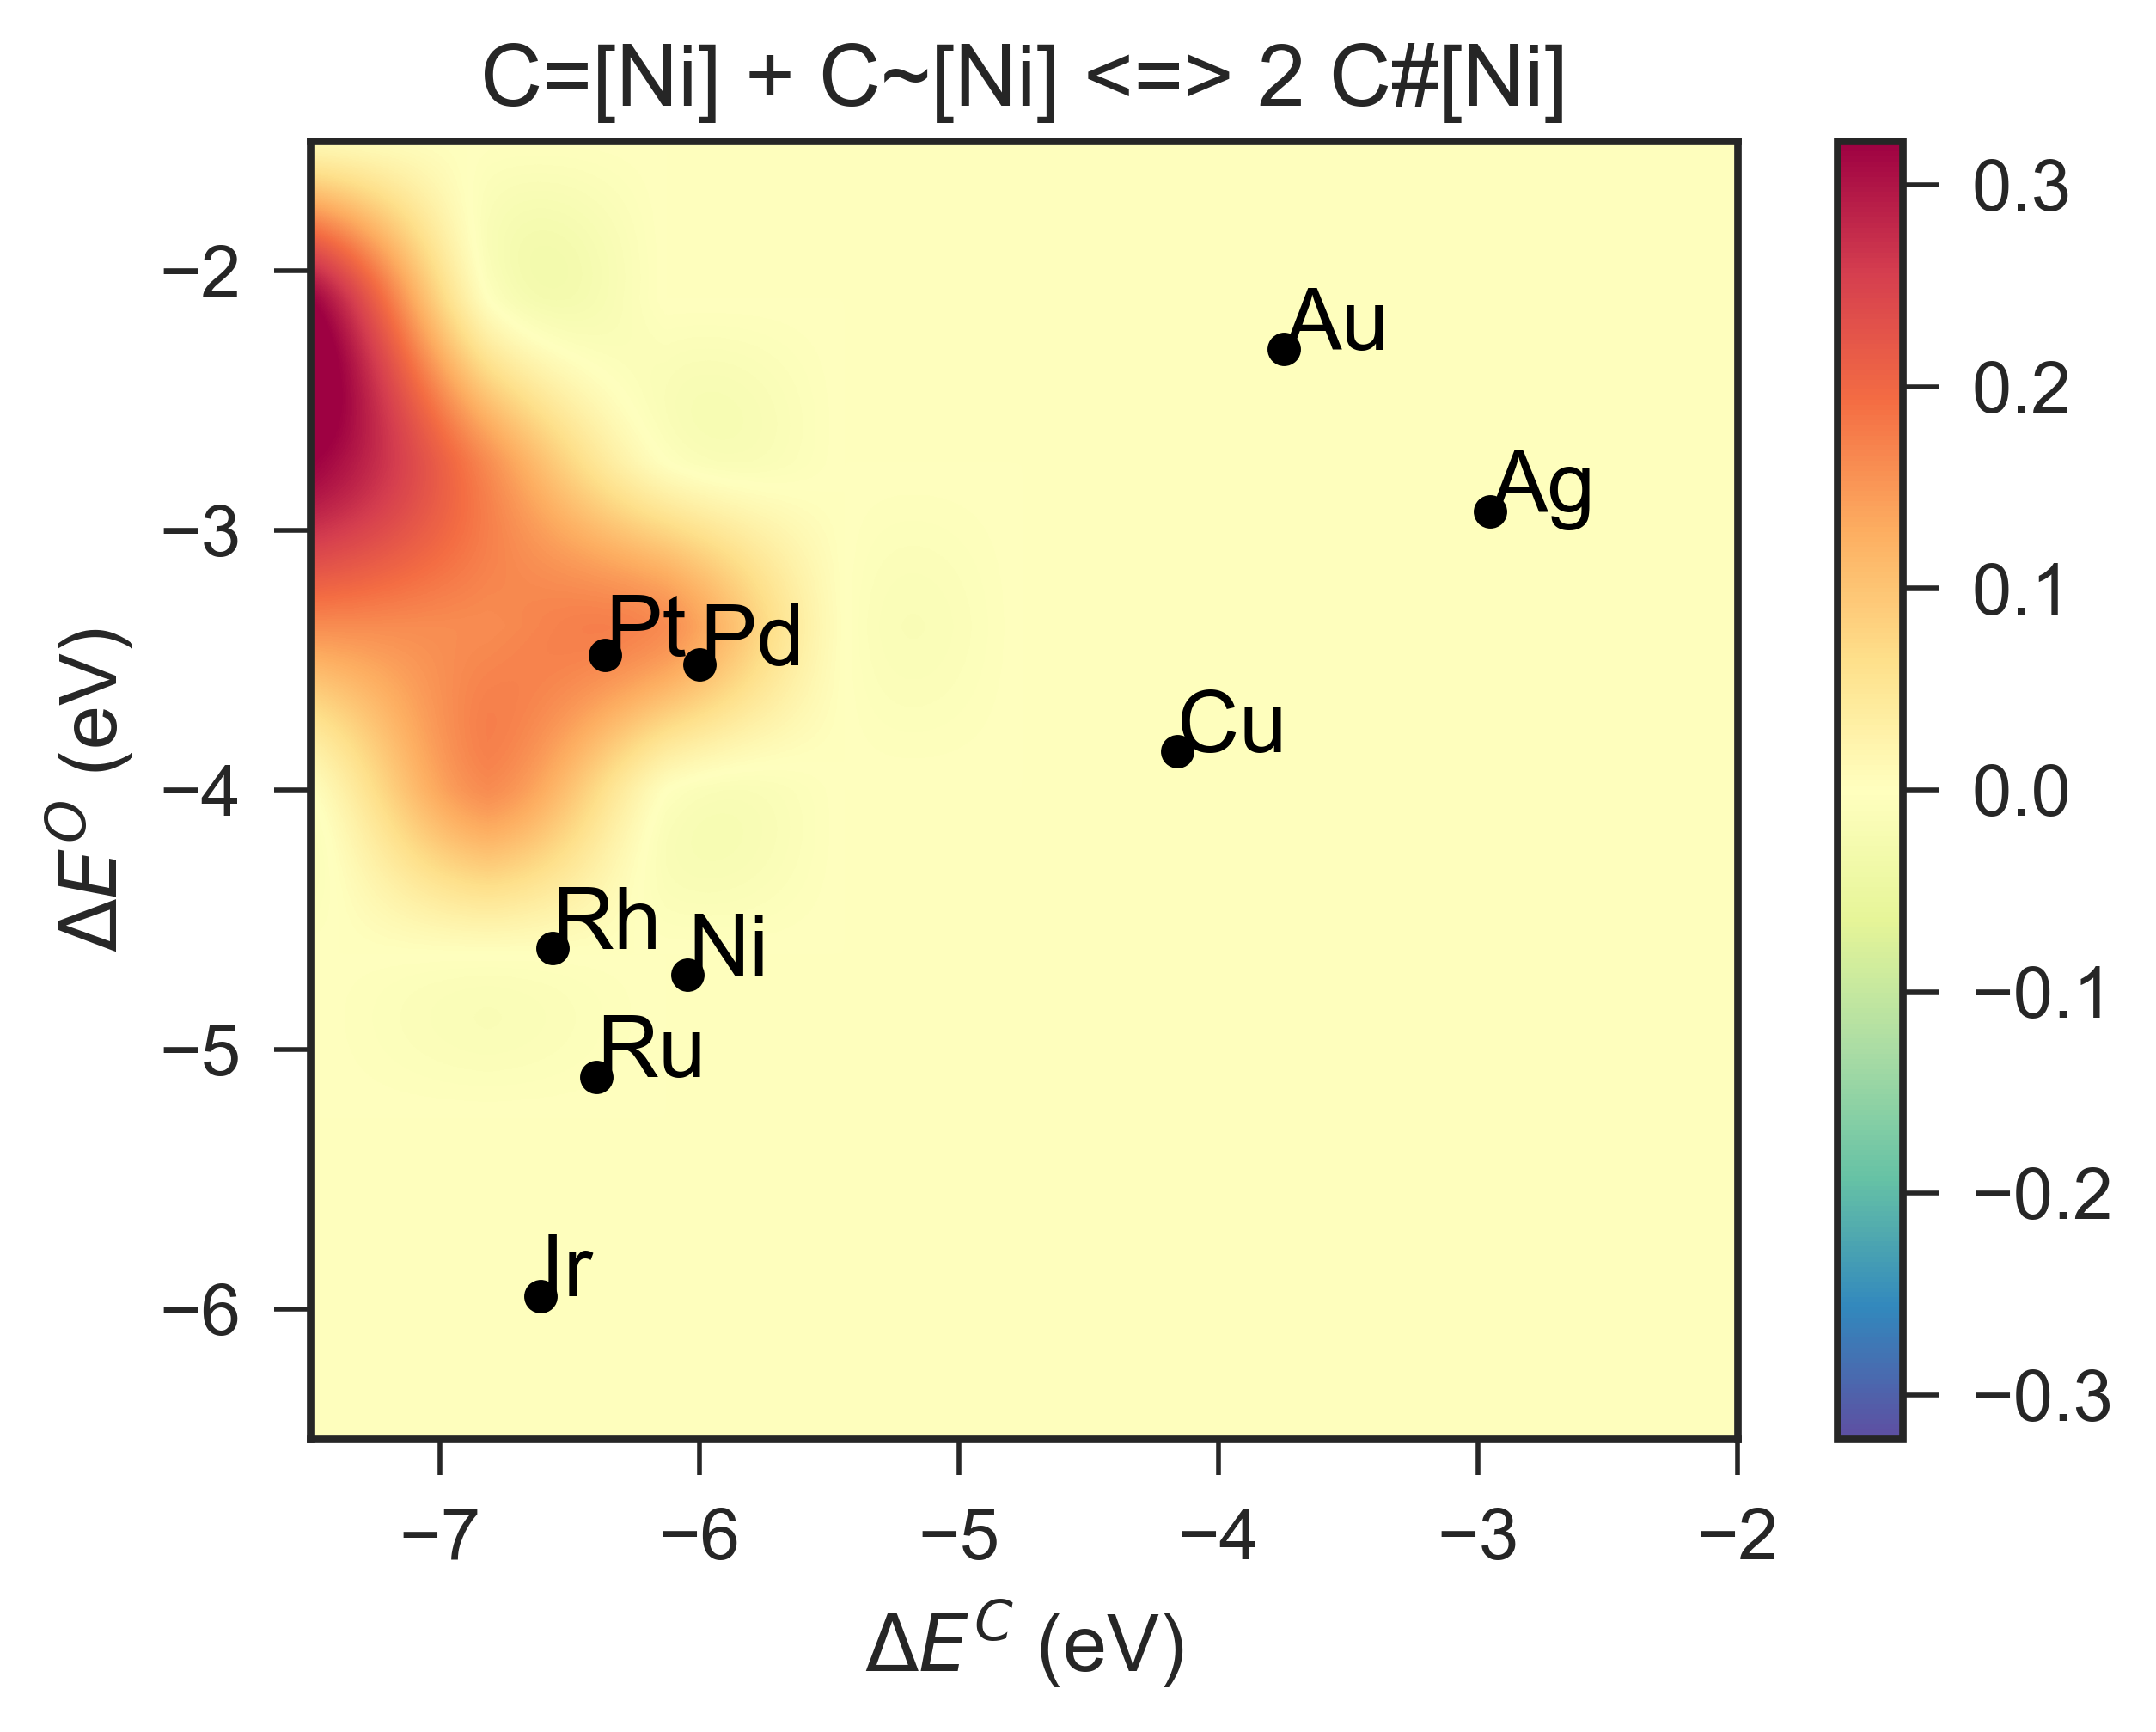

skipping OC[Ni] + C~[Ni] <=> OC=[Ni] + C#[Ni] because it's boring
skipping C~[Ni] + O=C[Ni] <=> C#[Ni] + O=C=[Ni] because it's boring
skipping OC[Ni] + C~[Ni] <=> C=[Ni] + OC#[Ni] because it's boring
skipping CC=[Ni] + O=C=[Ni] <=> CC#[Ni] + O=C[Ni] because it's boring
skipping O=C[Ni] + [Ni] <=> [Ni] + O=C=[Ni] because it's boring
skipping [C-]#[O+] + [Ni] <=> [C-]#[O+].[Ni] because it's boring
skipping CC=[Ni] + C#[Ni] <=> CC#[Ni] + C=[Ni] because it's boring
skipping OC=[Ni] + C#[Ni] <=> C=[Ni] + OC#[Ni] because it's boring
skipping CC=[Ni] + [Ni] <=> C[Ni] + C#[Ni] because it's boring
skipping OC=[Ni] + [Ni] <=> OC#[Ni] + [Ni] because it's boring
skipping CO + 2 [Ni] <=> CO[Ni] + [Ni] because it's boring
skipping CO[Ni] + [Ni] <=> C[Ni] + O=[Ni] because it's boring
skipping 2 O[Ni] <=> O + O=[Ni] + [Ni] because it's boring
skipping OC=[Ni] + O=C[Ni] <=> OC[Ni] + O=C=[Ni] because it's boring
skipping CC=[Ni] + C=[Ni] <=> CC#[Ni] + C[Ni] because it's boring
skipping O=C[Ni] + O[Ni] <

In [15]:
for rxn in reactions:
    sensitivities = rxn[1]
    
    sensitivities = np.array(sensitivities)
    if sum(abs(sensitivities)>1e-9) < 5:
        print "skipping {} because it's boring".format(rxn[0])
        continue
    MAX = 5
    #log_sensitivities = np.log10(abs(sensitivities))
    #a = np.log10(abs(sensitivities)) + MAX
    #log_sensitivities = a * (a>0) * (1-2*(sensitivities<0) )
    df = pd.DataFrame(index=np.unique(o_s), columns=np.unique(c_s))
    for c, o, s in zip(c_s, o_s, sensitivities):
        df[c][o] = s

    a = []
    for i in df.values: 
        a = a + list(i)

    sensitivities = np.array(a)
    
    sensitivities_grid = np.reshape(sensitivities, (grid_size,grid_size))
    
    #ax = sns.heatmap(sensitivities_grid, cmap="Spectral")
    MAX = np.max(abs(sensitivities_grid))
    plt.imshow(sensitivities_grid, interpolation='spline16', origin='lower', 
               extent=extent2, aspect='equal', cmap="Spectral_r",
              vmin=-1*MAX, vmax=MAX)
    for metal, coords in abildpedersen_energies.iteritems():
        color = {'Ag':'k','Au':'k','Cu':'k'}.get(metal,'k')
        plt.plot(coords[0], coords[1], 'o'+color)
        plt.text(coords[0], coords[1], metal, color=color)
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
    plt.xlabel('$\Delta E^C$ (eV)')
    plt.ylabel('$\Delta E^O$ (eV)')
    plt.title(rxn[0])
    plt.colorbar()
    plt.show()
    
    matplotlib.rcParams['figure.dpi'] = 500
    


In [10]:
# Plot the number of surface reactions
# num_surf_reactions

# reaction_counts_grid = np.log10(np.reshape(num_surf_reactions, (grid_size,grid_size)))
# plt.imshow(reaction_counts_grid.T, interpolation='none', origin='lower', extent=extent2, aspect='equal')
# plt.xlim(carbon_range2)
# plt.ylim(oxygen_range2)
# plt.xlabel('$\Delta E^C$ (eV)')
# plt.ylabel('$\Delta E^O$ (eV)')
# for e,n in zip(experiments,num_surf_reactions):
#     plt.text(e[0],e[1],n,color='w',ha='center', va='center')
# plt.colorbar()

In [11]:
# A linear one, just to check it looks the same
# reaction_counts_grid = np.reshape(num_surf_reactions, (grid_size,grid_size))
# ax = sns.heatmap(reaction_counts_grid.T[::-1,:], annot=True, fmt='d', square=True)